In [1]:
%load_ext autoreload
%autoreload 2
!source /home/murilo/RelNetCare/.env

In [161]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from ast import literal_eval
from pathlib import Path
import pathlib as pl 
import seaborn as sns
import pandas as pd
import os

from src.paths import LOCAL_DATA_PATH

possible_labels = {
    "per:positive_impression",
    "per:negative_impression",
    "per:acquaintance",
    "per:alumni",
    "per:boss",
    "per:subordinate",
    "per:client",
    "per:dates",
    "per:friends",
    "per:girl/boyfriend",
    "per:girl_boyfriend",
    "per:neighbor",
    "per:roommate",
    "per:children",
    "per:other_family",
    "per:parents",
    "per:siblings",
    "per:spouse",
    "per:place_of_residence",
    "per:place_of_birth",
    "per:visited_place",
    "per:origin",
    "per:employee_or_member_of",
    "per:schools_attended",
    "per:works",
    "per:age",
    "per:date_of_birth",
    "per:major",
    "per:place_of_work",
    "per:title",
    "per:alternate_names",
    "per:pet",
    "gpe:residents_of_place",
    "gpe:births_in_place",
    "gpe:visitors_of_place",
    "org:employees_or_members",
    "org:students",
    "unanswerable",
    "no_relation",
    "null_relation"
    }

possible_labels.update({label.split(':')[1] if ':' in label else label for label in possible_labels})


def get_report_paths(path):
    paths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == 'report.json':
                paths.append(pl.Path(os.path.join(root, file)))
                
    return paths

# Initial explode
def get_labels(df, col):
    df_exploded = df[col].explode()

    # Loop to further explode nested lists
    while df_exploded.apply(lambda x: isinstance(x, list) or (isinstance(x, str) and x.startswith('['))).any():
        # Apply literal_eval only if the item is a string representation of a list
        df_exploded = df_exploded.apply(lambda x: literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        df_exploded = df_exploded.explode()

    return df_exploded

def plot_word_cloud(label_counts, possible_true_labels, output_path):
    # Creating a color function
    def color_func(word, *args, **kwargs):
        return 'green' if word in possible_true_labels else 'red'

    # Generating the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func)
    wordcloud.generate_from_frequencies(label_counts)

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Predicted Labels')

    # Save the plot to the specified path
    wordcloud_output_path = output_path.parent / 'label_distribution_wordcloud.png'
    plt.savefig(wordcloud_output_path, bbox_inches='tight', dpi=600)  

    print(f"Word Cloud chart exported to\n{wordcloud_output_path}")
    plt.close()



def plot_label_distribution(p):
    # Read the JSON data
    df = pd.read_json(p, lines=True)

    # Processing the data
    if 'clsTskOnl' in str(p):
        predicted_labels = get_labels(df, 'predicted_labels')
        # possible_true_labels = get_labels(df, 'true_labels').unique().tolist()
    else:
        predicted_labels = df.predicted_labels.explode().dropna().apply(lambda x: x.get('relation', x.get('r')))
        # possible_true_labels = df.true_labels.explode().dropna().apply(lambda x: x.get('relation', x.get('r'))).unique().tolist()

    possible_true_labels = possible_labels

    # Counting the occurrences of each predicted label
    label_counts = predicted_labels.value_counts()

    # Calculate the dynamic height based on the number of labels
    min_height_per_label = 0.5  # Minimum height allocated for each label
    total_labels = len(label_counts)
    dynamic_height = total_labels * min_height_per_label

    # Creating the horizontal bar chart with dynamic figure size
    fig, ax = plt.subplots(figsize=(10, dynamic_height))
    sns.barplot(x=label_counts, y=label_counts.index, palette=['green' if label in possible_true_labels else 'red' for label in label_counts.index], ax=ax)
    plt.xlabel('Count')
    plt.ylabel('Predicted Labels')

    # Annotating the count on each bar in gray
    for index, (label, value) in enumerate(label_counts.items()):
        plt.text(value, index, str(value), color='gray')
        ax.get_yticklabels()[index].set_color('red' if label not in possible_true_labels else 'black')

    # Add legend
    green_patch = mpatches.Patch(color='green', label='Possible Labels')
    red_patch = mpatches.Patch(color='red', label='Hallucinated Labels')
    plt.legend(handles=[green_patch, red_patch], loc='lower right')
    plt.title('Predicted Label Distribution')

    # Save the plot to the specified path
    output_path = Path(p).parent / 'label_distribution.png'
    plt.savefig(output_path, bbox_inches='tight')

    print(f"Chart exported to\n{output_path}")
    # Close the plot to free up memory
    plt.close()
    
    return label_counts, possible_true_labels


if __name__ == "__main__":
    reports_path = LOCAL_DATA_PATH / 'reports'
    report_paths = get_report_paths(reports_path)

    for p in report_paths:
        df = pd.read_json(p, lines=True)
        label_counts, possible_true_labels = plot_label_distribution(p)
        plot_word_cloud(label_counts, possible_true_labels, Path(p))



Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-2cls-undersampled-llama-clsTskOnl/llama-7B-hf/label_distribution.png
Word Cloud chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-2cls-undersampled-llama-clsTskOnl/llama-7B-hf/label_distribution_wordcloud.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-undersampled-llama-clsTskOnl/llama-7B-hf/label_distribution.png
Word Cloud chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-undersampled-llama-clsTskOnl/llama-7B-hf/label_distribution_wordcloud.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-undersampled-llama-clsTskOnl/gpt-3.5-turbo/label_distribution.png
Word Cloud chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-undersampled-llama-clsTskOnl/gpt-3.5-turbo/label_distribution_wordcloud.png
Chart exported to
/home/murilo/RelNetCare/data/reports/di

Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-2cls-undersampled-llama-clsTskOnl/llama-7B-hf/label_distribution.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-undersampled-llama-clsTskOnl/llama-7B-hf/label_distribution.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-undersampled-llama-clsTskOnl/gpt-3.5-turbo/label_distribution.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-llama-clsTskOnl/llama-7B-hf/label_distribution.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-llama-clsTskOnl/facebook/bart-large/label_distribution.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps/llama-7B-hf/label_distribution.png
Chart exported to
/home/murilo/RelNetCare/data/reports/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps

In [83]:
# def plot_label_distribution(p):
#     # Read the JSON data
#     df = pd.read_json(p, lines=True)

#     # Processing the data
#     if 'clsTskOnl' in str(p):
#         predicted_labels = get_labels(df, 'predicted_labels')
#         possible_true_labels = get_labels(df, 'true_labels').unique().tolist()
#     else:
#         predicted_labels = df.predicted_labels.explode().apply(lambda x: x.get('relation', x.get('r')))
#         possible_true_labels = df.true_labels.explode().dropna().apply(lambda x: x.get('relation', x.get('r'))).unique().tolist()

#     # Counting the occurrences of each predicted label
#     label_counts = predicted_labels.value_counts()

#     # Calculate the dynamic height based on the number of labels
#     min_height_per_label = 0.5  # Minimum height allocated for each label
#     total_labels = len(label_counts)
#     dynamic_height = total_labels * min_height_per_label

#     # Creating the horizontal bar chart with dynamic figure size
#     plt.figure(figsize=(10, dynamic_height))
#     sns.barplot(x=label_counts, y=label_counts.index, palette=['green' if label in possible_true_labels else 'red' for label in label_counts.index])
#     plt.xlabel('Count')
#     plt.ylabel('Predicted Labels')

#     # Annotating the count on each bar in gray
#     for index, value in enumerate(label_counts):
#         plt.text(value, index, str(value), color='gray')

#     # Add legend
#     green_patch = mpatches.Patch(color='green', label='Possible Labels')
#     red_patch = mpatches.Patch(color='red', label='Hallucinated Labels')
#     plt.legend(handles=[green_patch, red_patch], loc='lower right')
#     plt.title('Predicted Label Distribution')

#     # Save the plot to the specified path
#     output_path = Path(p).parent / 'label_distribution.png'
#     plt.savefig(output_path, bbox_inches='tight')

#     print(f"Chart exported to\n{output_path}")
#     # Close the plot to free up memory
#     plt.close()


In [79]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import seaborn as sns

# predicted_labels = df.predicted_labels.explode().apply(lambda x: x.get('relation', x.get('r')))

# possible_true_labels = df.true_labels.explode().dropna().apply(lambda x: x.get('relation', x.get('r'))).unique().tolist()


# # Counting the occurrences of each predicted label
# # Counting the occurrences of each predicted label
# label_counts = predicted_labels.value_counts()

# green_patch = mpatches.Patch(color='green', label='Possible Labels')
# red_patch = mpatches.Patch(color='red', label='Hallucinated Labels')


# # Mapping the colors based on whether the label is in possible true labels
# colors = ['green' if label in possible_true_labels else 'red' for label in label_counts.index]

# # Calculate the dynamic height based on the number of labels
# min_height_per_label = 0.5  # Minimum height allocated for each label
# total_labels = len(label_counts)
# dynamic_height = total_labels * min_height_per_label

# # Creating the horizontal bar chart with dynamic figure size
# plt.figure(figsize=(10, dynamic_height))

# # Creating the horizontal bar chart
# sns.barplot(x=label_counts, y=label_counts.index, palette=colors)
# plt.xlabel('Count')
# plt.ylabel('Predicted Labels')
# # Annotating the count on each bar
# for index, value in enumerate(label_counts):
#     plt.text(value, index, str(value), color='gray')

# plt.legend(handles=[green_patch, red_patch], loc='lower right')
# plt.title('Predicted Label Distribution')
# plt.show()

Accuracy on the test-set: 0.5257731958762887


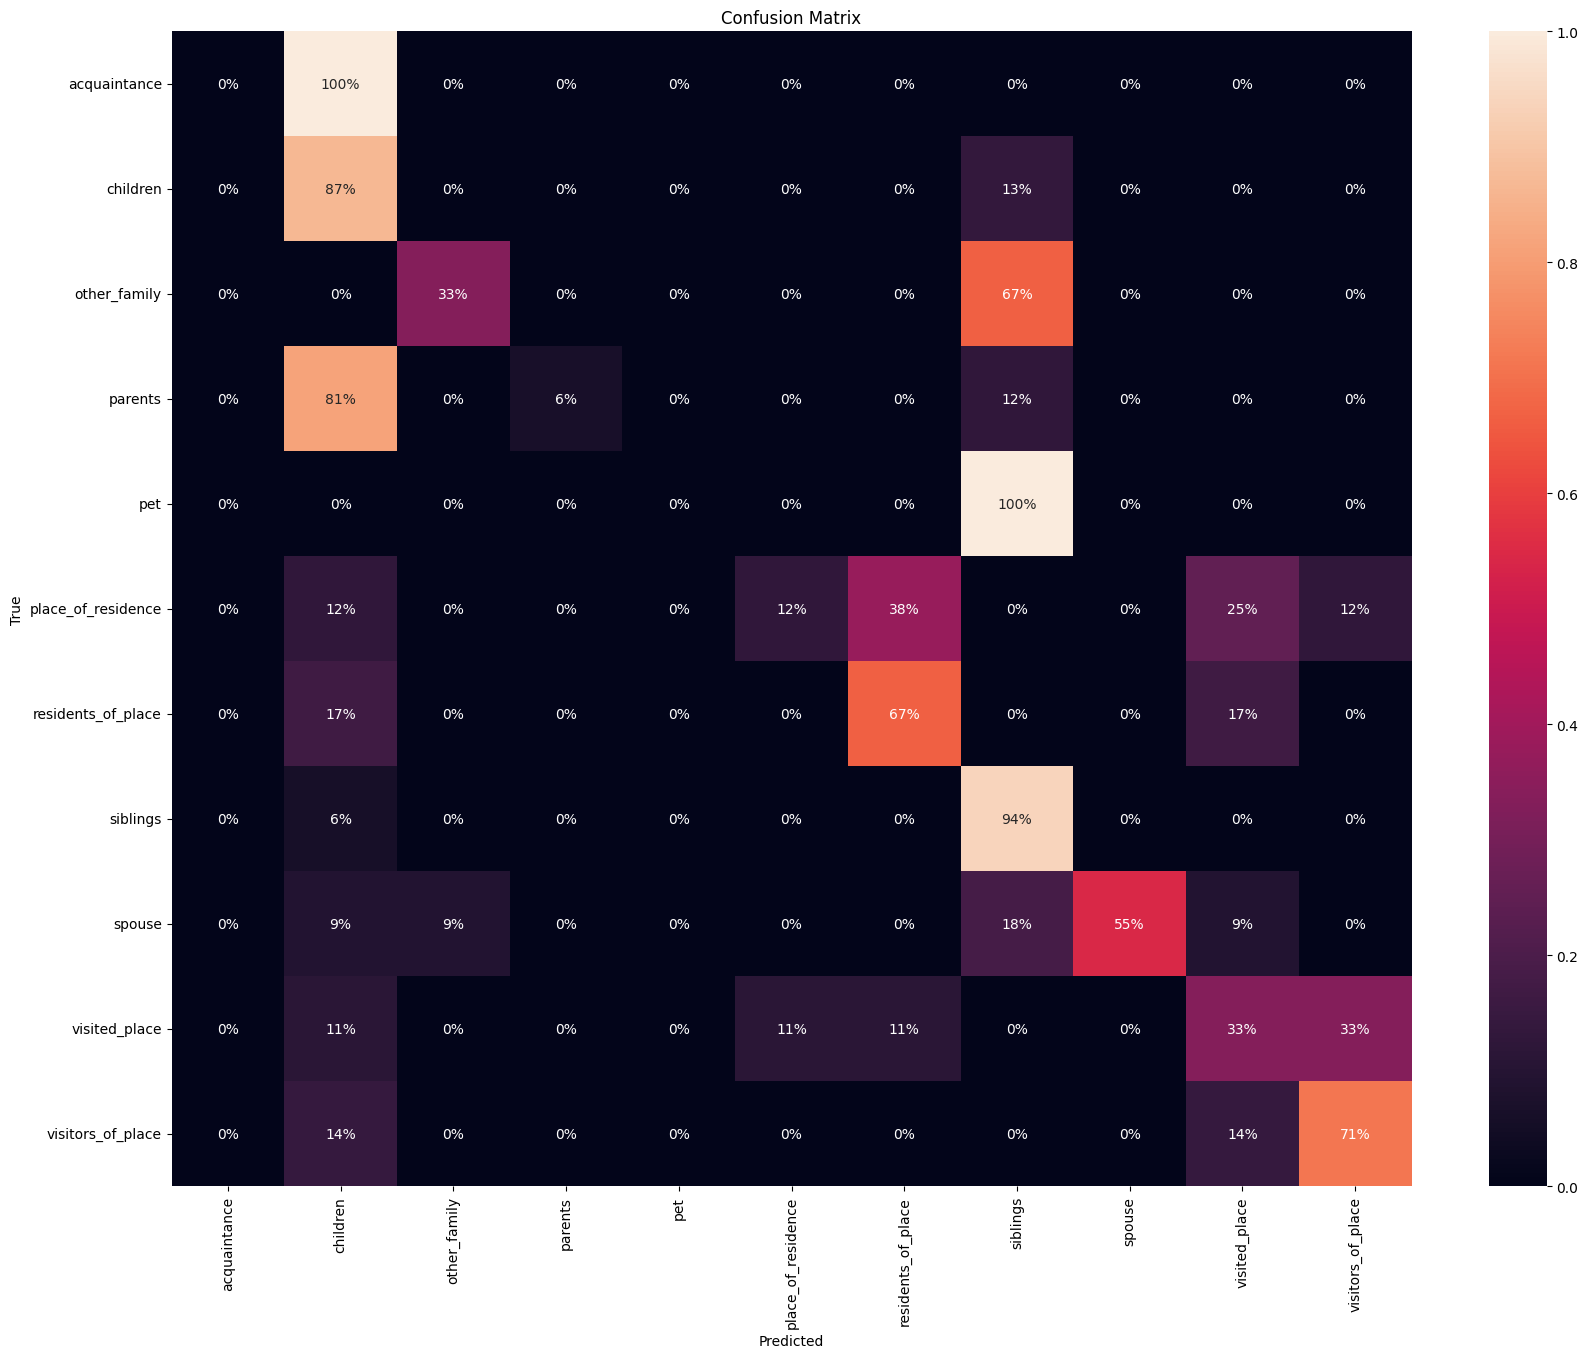

In [28]:
# TODO: Convert to script! Sanetizes LLM's report dump according to confusion matrix!
reorder_cm = True  # Set to False to skip reordering
is_multi_label = True
root_path= "/home/murilo/RelNetCare/data/reports/dialog-re-12cls-with-no-relation-undersampled-llama/custom/ensemble-36cls"
# root_path = "/home/murilo/RelNetCare/data/reports/dialog-re-llama-37cls-clsTskOnl-instrB-shfflDt/llama-7B-hf"
data_path = f"{root_path}/report.json"
from src.evaluating.mlmc import draw_cm
import numpy as np
import pandas as pd
df = pd.read_json(data_path, lines=True)

import json
rel_path = "/home/murilo/RelNetCare/data/raw/dialog-re/relation_label_dict.json"
with open(rel_path) as fp:
    relations = json.loads(fp.read())
    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
mlb = MultiLabelBinarizer()
ground_truth_raw = df.true_labels.apply(lambda x: eval(x[0]) if isinstance(x, str) else x)
predictions_raw = df.predicted_labels.apply(lambda x: eval(x[0]) if isinstance(x, str) else x)

has_dict_flag = any(any(isinstance(item, dict) for item in list_) for list_ in ground_truth_raw)

if has_dict_flag:
    ground_truth_raw = ground_truth_raw.apply(lambda item: [x.get('relation', x.get('r')) for x in item])
    predictions_raw = predictions_raw.apply(lambda item: [x.get('relation', x.get('r')) for x in item])

ground_truth_mlb = mlb.fit_transform(ground_truth_raw)
predictions_mlb = mlb.transform(predictions_raw)

# Transform the multilabel problem into multi-class
ground_truth_mc = ground_truth_mlb.argmax(axis=1)
predictions_mc = predictions_mlb.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(ground_truth_mc, predictions_mc, normalize='true')

# Use Seaborn to plot the confusion matrix
# readable_classes = df.true_labels.apply(lambda x: eval(x[0])[0]).explode().unique()
readable_classes = [c for c in mlb.classes_]
# readable_classes = [r.split(':')[-1] for rid,r in relations.items()]

# Create the heatmap
# plt.figure(figsize=(20, 15))
# ax = sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=readable_classes, yticklabels=readable_classes)

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()
if not is_multi_label:
    if reorder_cm:
        ref_order = [r.split(':')[-1] for rid, r in relations.items()]
        ref_order += ['no_relation']

        # Find the new order of indices based on ref_order
        new_order_indices = []
        missing_labels = []

        for label in ref_order:
            try:
                new_order_indices.append(readable_classes.index(label))
            except ValueError:
                print(f"Label '{label}' not in readable_classes.")
                missing_labels.append(label)

        # Reorder the confusion matrix rows and columns
        cm_reordered = cm[new_order_indices, :]
        cm_reordered = cm_reordered[:, new_order_indices]

        # Plot the reordered matrix
        plt.figure(figsize=(20, 15))
        ax = sns.heatmap(cm_reordered, annot=True, fmt='.0%',
                        xticklabels=[label for label in ref_order if label not in missing_labels],
                        yticklabels=[label for label in ref_order if label not in missing_labels])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    else:
        # Plot the original matrix without reordering
        plt.figure(figsize=(20, 15))
        ax = sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=readable_classes, yticklabels=readable_classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

else:
    # Ensure ground_truth_mlb and predictions_mlb are in the correct format
    # and have the same shape
    assert ground_truth_mlb.shape == predictions_mlb.shape, "Shapes of ground truth and predictions must match"

    classes = mlb.classes_
    draw_cm(ground_truth_mlb, predictions_mlb, classes, normalize=True)
    
plt.savefig(f"{root_path}/confusion_matrix.png")

class_metrics_path = f"{root_path}/class_metrics.json"
with open(class_metrics_path) as fp:
    exp_group = json.loads(fp.read())['exp_group']
ground_truth = ground_truth_raw.apply(lambda x: x[0] if len(x) > 0 else 'no_relation')
predictions = predictions_raw.apply(lambda x: x[0] if len(x) > 0 else 'no_relation')
unique_ground_truth_labels = set(ground_truth_raw.explode().dropna().unique())

predictions = [p if p in unique_ground_truth_labels else 'unanswerable' for p in predictions.tolist()]
classificationRep_dict = classification_report(
    ground_truth, predictions, output_dict=True)

# Compute micro and macro f1-score separately
f1_micro = f1_score(ground_truth, predictions, average='micro')
f1_macro = f1_score(ground_truth, predictions, average='macro')

# Compute micro and macro precision
precision_micro = precision_score(ground_truth, predictions, average='micro')
precision_macro = precision_score(ground_truth, predictions, average='macro')

# Compute micro and macro recall
recall_micro = recall_score(ground_truth, predictions, average='micro')
recall_macro = recall_score(ground_truth, predictions, average='macro')

# Extract per-class metrics
per_class_metrics = {}
for label, metrics in classificationRep_dict.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    lbl_clean = label.split(':')[-1]
    per_class_metrics[lbl_clean] = {
        "precision": metrics['precision'],
        "recall": metrics['recall'],
        "f1": metrics['f1-score'],
        "support": metrics['support'],
    }

# Compile everything into one dictionary
metrics_dict = {
    "micro_avg": {
        "precision": precision_micro,
        "recall": recall_micro,
        "f1": f1_micro
    },
    "macro_avg": {
        "precision": precision_macro,
        "recall": recall_macro,
        "f1": f1_macro
    },
    "per_class": per_class_metrics,
    "exp_group": exp_group
}

np.savetxt(f"{root_path}/confusion_matrix.csv", cm, delimiter=",")

with open(class_metrics_path, 'w', encoding='utf8') as fp:
    fp.write(json.dumps(metrics_dict, indent=4))
    




In [26]:
[p for p in predictions]

['parents',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'children',
 'unanswerable',
 'unanswerable',
 'spouse',
 'siblings',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'siblings',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'residents_of_place',
 'children',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'siblings',
 'unanswerable',
 'place_of_residence',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'siblings',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'visitors_of_place',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'siblings',
 '

In [27]:
ground_truth

0      siblings
1          None
2          None
3          None
4          None
         ...   
190      spouse
191      spouse
192        None
193    siblings
194        None
Name: true_labels, Length: 195, dtype: object

In [15]:
predictions

0                  parents
1      positive_impression
2                  friends
3             unanswerable
4                   alumni
              ...         
190                friends
191               children
192                     []
193                     []
194                friends
Name: predicted_labels, Length: 195, dtype: object

In [12]:
mask1 = ground_truth_raw.apply(lambda x: 'parents' in x)
mask2 = predictions_raw.apply(lambda x: 'parents' in x)
ground_truth_raw[(mask1 & mask2)]
# predictions_raw[(mask1 & mask2)]

40    {parents, children}
Name: true_labels, dtype: object

In [13]:
ground_truth_mlb[mask1&mask2]

array([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
predictions_mlb[mask1&mask2]


array([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [27]:
f"{root_path}/confusion_matrix.png"

'/home/murilo/RelNetCare/data/reports/dialog-re-12cls-with-no-relation-undersampled-llama/custom/ensemble-36cls/confusion_matrix.png'

Accuracy on the test-set: 0.5257731958762887


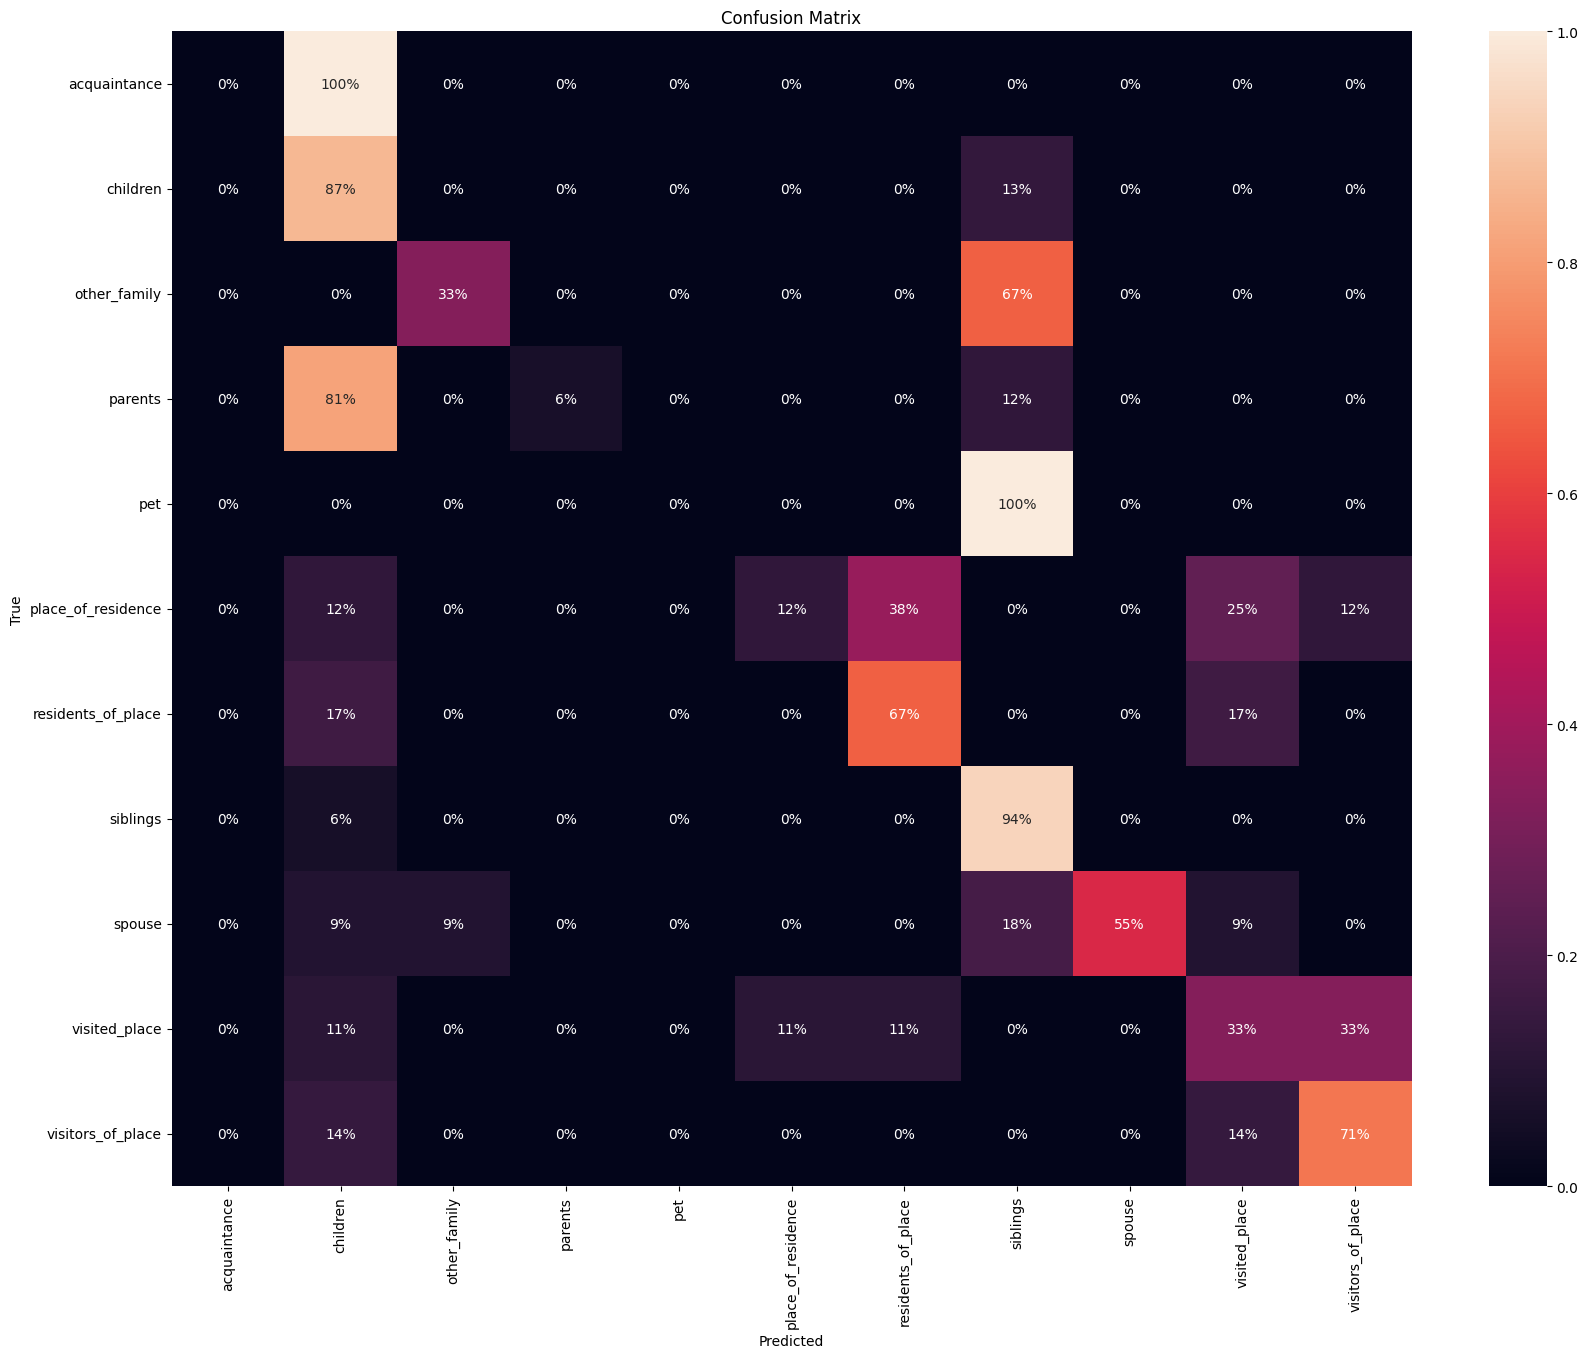

83

/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['aunt', 'births_in_place', 'colleague', 'doctor', 'girl/boyfriend', 'likes', 'neighbors', 'null_relation', 'parent', 'place_of_birth', 'sibling'] will be ignored
  warnings.warn(


Label 'place_of_birth' not in readable_classes.
Label 'births_in_place' not in readable_classes.
Label 'unanswerable' not in readable_classes.


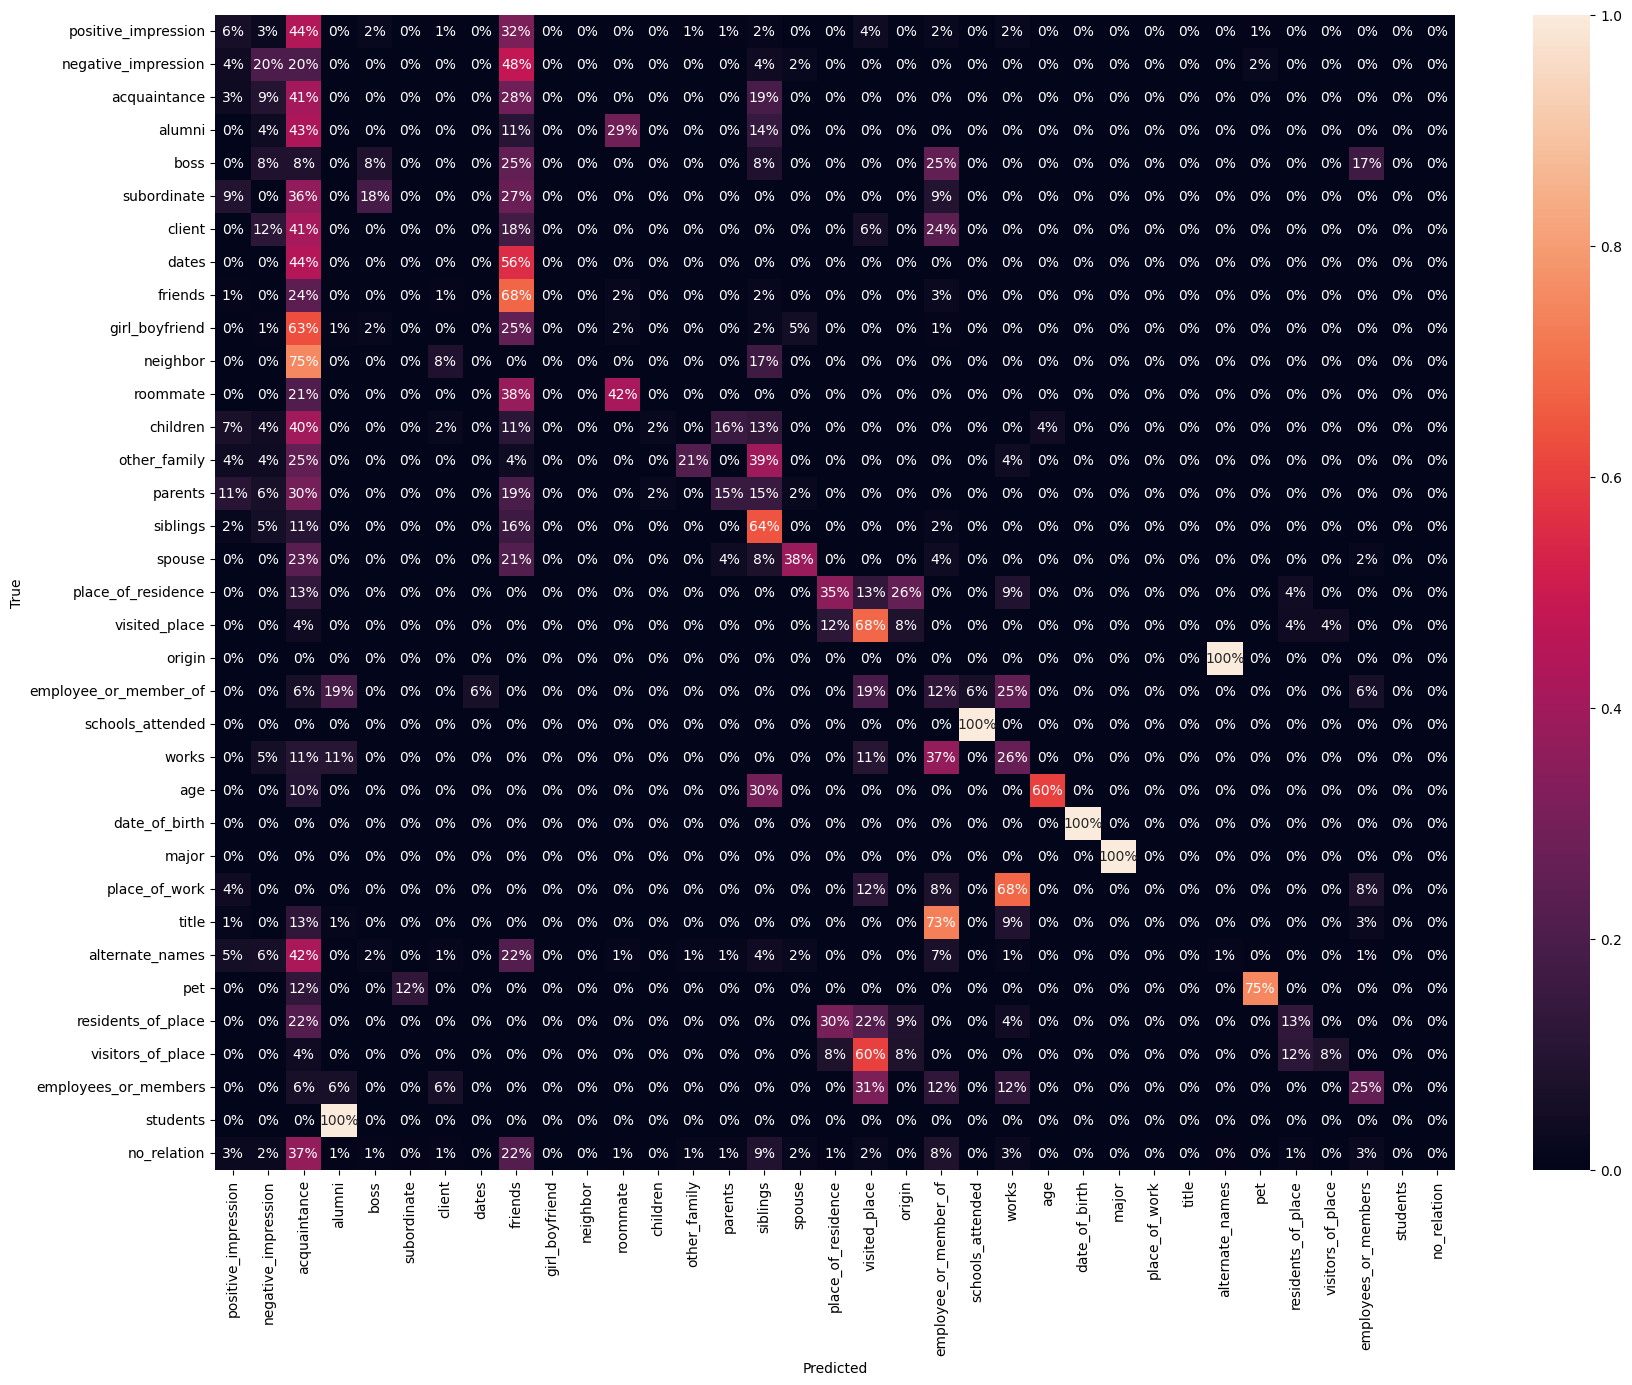

/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

In [13]:
# # TODO: Convert to script! Sanetizes LLM's report dump according to confusion matrix!
# root_path= "/home/murilo/RelNetCare/data/reports/dialog-re-37cls-with-no-relation-undersampled-llama-clsTskOnl/gpt-3.5-turbo"
# # root_path = "/home/murilo/RelNetCare/data/reports/dialog-re-llama-37cls-clsTskOnl-instrB-shfflDt/llama-7B-hf"
# data_path = f"{root_path}/report.json"
# import numpy as np
# import pandas as pd
# df = pd.read_json(data_path, lines=True)

# import json
# rel_path = "/home/murilo/RelNetCare/data/raw/dialog-re/relation_label_dict.json"
# with open(rel_path) as fp:
#     relations = json.loads(fp.read())
    
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MultiLabelBinarizer

# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
# mlb = MultiLabelBinarizer()
# ground_truth_raw = df.true_labels.apply(lambda x: eval(x[0]) if isinstance(x, str) else x)
# predictions_raw = df.predicted_labels.apply(lambda x: eval(x[0]) if isinstance(x, str) else x)
# ground_truth_mlb = mlb.fit_transform(ground_truth_raw)
# predictions_mlb = mlb.transform(predictions_raw)

# # Transform the multilabel problem into multi-class
# ground_truth_mc = ground_truth_mlb.argmax(axis=1)
# predictions_mc = predictions_mlb.argmax(axis=1)

# # Compute the confusion matrix
# cm = confusion_matrix(ground_truth_mc, predictions_mc, normalize='true')

# # Use Seaborn to plot the confusion matrix
# # readable_classes = df.true_labels.apply(lambda x: eval(x[0])[0]).explode().unique()
# readable_classes = [c for c in mlb.classes_]
# # readable_classes = [r.split(':')[-1] for rid,r in relations.items()]

# # Create the heatmap
# # plt.figure(figsize=(20, 15))
# # ax = sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=readable_classes, yticklabels=readable_classes)

# # plt.xlabel('Predicted')
# # plt.ylabel('True')
# # plt.show()

# ref_order = [r.split(':')[-1] for rid,r in relations.items()]
# ref_order = [r.split(':')[-1] for rid,r in relations.items()] + ['no_relation']

# # Find the new order of indices based on ref_order
# new_order_indices = []
# missing_labels = []

# for label in ref_order:
#     try:
#         new_order_indices.append(readable_classes.index(label))
#     except ValueError:
#         print(f"Label '{label}' not in readable_classes.")
#         missing_labels.append(label)

# # Reorder the confusion matrix rows
# cm_reordered = cm[new_order_indices, :]

# # Reorder the confusion matrix columns
# cm_reordered = cm_reordered[:, new_order_indices]

# # Now plot the reordered matrix
# plt.figure(figsize=(20, 15))
# ax = sns.heatmap(cm_reordered, annot=True, fmt='.0%', xticklabels=[label for label in ref_order if label not in missing_labels], yticklabels=[label for label in ref_order if label not in missing_labels])
# plt.savefig(f"{root_path}/confusion_matrix.png")

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# class_metrics_path = f"{root_path}/class_metrics.json"
# with open(class_metrics_path) as fp:
#     exp_group = json.loads(fp.read())['exp_group']
# ground_truth = ground_truth_raw.apply(lambda x: x[0])
# predictions = predictions_raw.apply(lambda x: x[0])
# predictions = [p if p in set(ground_truth) else 'unanswerable' for p in predictions]
# classificationRep_dict = classification_report(
#     ground_truth, predictions, output_dict=True)

# # Compute micro and macro f1-score separately
# f1_micro = f1_score(ground_truth, predictions, average='micro')
# f1_macro = f1_score(ground_truth, predictions, average='macro')

# # Compute micro and macro precision
# precision_micro = precision_score(ground_truth, predictions, average='micro')
# precision_macro = precision_score(ground_truth, predictions, average='macro')

# # Compute micro and macro recall
# recall_micro = recall_score(ground_truth, predictions, average='micro')
# recall_macro = recall_score(ground_truth, predictions, average='macro')


# # Extract per-class metrics
# per_class_metrics = {}
# for label, metrics in classificationRep_dict.items():
#     if label in ['accuracy', 'macro avg', 'weighted avg']:
#         continue
#     lbl_clean = label.split(':')[-1]
#     per_class_metrics[lbl_clean] = {
#         "precision": metrics['precision'],
#         "recall": metrics['recall'],
#         "f1": metrics['f1-score'],
#         "support": metrics['support'],
#     }

# # Compile everything into one dictionary
# metrics_dict = {
#     "micro_avg": {
#         "precision": precision_micro,
#         "recall": recall_micro,
#         "f1": f1_micro
#     },
#     "macro_avg": {
#         "precision": precision_macro,
#         "recall": recall_macro,
#         "f1": f1_macro
#     },
#     "per_class": per_class_metrics,
#     "exp_group": exp_group
# }


# np.savetxt(f"{root_path}/confusion_matrix.csv", cm, delimiter=",")

# with open(class_metrics_path, 'w', encoding='utf8') as fp:
#     fp.write(json.dumps(metrics_dict, indent=4))

In [ ]:
metrics_dict['per_class']

In [ ]:
# import json
# from src.processing.dialogre_processing import format_relation
# import os
# import pandas as pd


# def dump_readme(data_path):
#     files = os.listdir(data_path)
#     data_frames = []

#     files = [f for f in files if f != "relation_label_dict.json" and f.endswith('.json')]

#     for file in files:
#         with open(os.path.join(data_path, file), 'r') as f:
#             data = json.load(f)
        
#         df = pd.DataFrame(data, columns=['dialog', 'relation_info'])
#         df['dataset_name'] = file.replace('.json', '')
#         data_frames.append(df)

#     final_df = pd.concat(data_frames, ignore_index=True)
#     x_df = final_df.explode('relation_info')
#     x_df['r'] = x_df['relation_info'].apply(format_relation)
#     # Drop rows where 'r' is None or NaN
#     x_df.dropna(subset=['r'], inplace=True)
#     x_df['dialog'] = x_df['dialog'].astype(str)
#     # Now backtrack to create the other DataFrames
#     final_df = x_df.groupby(['dialog', 'dataset_name']).first().reset_index()


#     # Create a pivot table
#     # Create a pivot table
#     pivot_df = pd.pivot_table(x_df, values='relation_info', index=['r'], columns=['dataset_name'], aggfunc='count', fill_value=0)

#     # Rename the columns and calculate the proportion and total
#     pivot_df.columns = [f'count_{col}' for col in pivot_df.columns]
#     pivot_df['total'] = pivot_df.sum(axis=1)
#     pivot_df['proportion'] = (pivot_df['total'] / pivot_df['total'].sum() * 100).apply(lambda x: f"{x:.1f}%")

#     # Split 'r' into 'rid' and 'relation'
#     pivot_df.reset_index(inplace=True)
#     pivot_df[['rid', 'r']] = pivot_df['r'].str.split('__', expand=True)
#     pivot_df = pivot_df.sort_values('total', ascending=False)
    
#     readme_text = f"""
# # Data Descriptions

# ## Dataset Size 

# ### Dialogue Counts

# { final_df.dataset_name.value_counts().to_markdown() }

# ### Relation Counts

# { x_df.dataset_name.value_counts().to_markdown() }

# ## Relationship Types (Relation Counts)

# {pivot_df.set_index('rid').to_markdown()}
#     """

#     with open(os.path.join(data_path, "README.md"), "w") as f:
#         f.write(readme_text)

# dump_readme('/home/murilo/RelNetCare/data/processed/dialog-re-12cls-with-no-relation')


In [ ]:
from src.processing.dialogre_processing import dump_readme
dump_readme('/home/murilo/RelNetCare/data/processed/dialog-re-2cls-undersampled-enriched')


In [ ]:
# overwrite class metrics on pipeline
from src.utils import fix_cls_metrics_dump

data_stem = 'dialog-re-36cls-llama-clsTskOnl'
model_name = 'llama-7B-hf'

fix_cls_metrics_dump(data_stem, model_name)

In [ ]:
data_folder = "/home/murilo/RelNetCare/data/raw/dialog-re-realRAW"
import json
import os


data = []
for f in os.listdir(data_folder):
    if 'relation_label_dict' not in f:
        data_path =  f"{data_folder}/{f}"
        
    with open(data_path, encoding='utf-8') as fp:
        tmp_data = json.load(fp)
    
    data.extend(tmp_data)

data_path


In [ ]:
data_dict = {str(r['rid'][0]): r['r'][0] for d in data for r in d[1]}
data_dict = {str(r['rid'][0]): r['r'][0] for d in data for r in d[1]}
sorted_data_dict = {str(k): v for k, v in sorted(data_dict.items(), key=lambda item: int(item[0]))}

with open(f"{data_folder}/relation_label_dict.json", encoding='utf-8', mode='w') as fp:
    json.dump(sorted_data_dict, fp)

In [ ]:
# def compute_failure_modes(row, relations):
#     output = {}
#     true_label_dicts = row['true_labels']
#     pred_label_dicts = row['predicted_labels']

#     true_labels_str = [str(l) for l in true_label_dicts] if len(true_label_dicts) > 0 else ['null_relation']
#     pred_labels_str = [str(l) for l in pred_label_dicts] if len(pred_label_dicts) > 0 else ['null_relation']
    
#     for r in relations:
#         true_labels_with_rel = [l for l in true_labels_str if r in l]
#         pred_labels_with_rel = [l for l in pred_labels_str if r in l]
        
#         tp_list = [l for l in true_labels_with_rel if l in pred_labels_with_rel]
#         fp_list = [l for l in pred_labels_with_rel if l not in true_labels_with_rel]
#         fn_list = [l for l in true_labels_with_rel if l not in pred_labels_with_rel]
#         tn_list = [l for l in pred_labels_with_rel if l not in fp_list]  # Tweaked this line
#         tn_list = [l for l in relations if l not in true_labels_with_rel and l not in pred_labels_with_rel]


#         output[r] = {
#             'list': {
#                 'tp': tp_list,
#                 'fp': fp_list,
#                 'tn': tn_list,  # Also tweaked this
#                 'fn': fn_list
#             },
#             'counts': {
#                 'tp': len(tp_list),
#                 'fp': len(fp_list),
#                 'tn': len(tn_list),  # And this
#                 'fn': len(fn_list),
#             }
#         }
#     return output



In [ ]:
data = ["acquaintance", "age", "alternate_names", "alumni", "births_in_place", "boss", "children", "client", "date_of_birth", "dates", "employee_or_member_of", "employees_or_members", "friends", "girl/boyfriend", "major", "negative_impression", "neighbor", "no_relation", "origin", "other_family", "parents", "pet", "place_of_birth", "place_of_residence", "place_of_work", "positive_impression", "residents_of_place", "roommate", "schools_attended", "siblings", "spouse", "students", "subordinate", "title", "unanswerable", "visited_place", "visitors_of_place", "works"]

In [ ]:
# import numpy as np
# entity_pairs = [(1,2), (1,2), (1,2), (0,1,2)]
# pred_labels = np.ones((len(entity_pairs),))
# pred_labels

In [ ]:
# DUMP README
# # dump read_me
import pandas as pd
import json
import os


def format_relation(x):
    try:
        return f"{x['rid'][0]:02}__{x['r'][0]}"
    except TypeError as e:
        print(f"TypeError for item {x}: {e}")
        return None  # or some default value



def dump_readme(data_path):
    files = os.listdir(data_path)
    data_frames = []

    files = [f for f in files if f != "relation_label_dict.json" and f.endswith('.json')]

    for file in files:
        with open(os.path.join(data_path, file), 'r') as f:
            data = json.load(f)
        
        df = pd.DataFrame(data, columns=['dialog', 'relation_info'])
        df['dataset_name'] = file.replace('.json', '')
        data_frames.append(df)

    final_df = pd.concat(data_frames, ignore_index=True)
    x_df = final_df.explode('relation_info')
    x_df['r'] = x_df['relation_info'].apply(format_relation)

    # Create a pivot table
    pivot_df = pd.pivot_table(x_df, values='relation_info', index=['r'], columns=['dataset_name'], aggfunc='count', fill_value=0)

    # Rename the columns and calculate the proportion and total
    pivot_df.columns = [f'count_{col}' for col in pivot_df.columns]
    pivot_df['total'] = pivot_df.sum(axis=1)
    pivot_df['proportion'] = (pivot_df['total'] / pivot_df['total'].sum() * 100).apply(lambda x: f"{x:.1f}%")

    # Split 'r' into 'rid' and 'relation'
    pivot_df.reset_index(inplace=True)
    pivot_df[['rid', 'r']] = pivot_df['r'].str.split('__', expand=True)
    pivot_df = pivot_df.sort_values('total', ascending=False)
    
    readme_text = f"""
# Data Descriptions

## Dataset Size 

### Dialogue Counts

{ final_df.dataset_name.value_counts().to_markdown() }

### Relation Counts

{ x_df.dataset_name.value_counts().to_markdown() }

## Relationship Types (Relation Counts)

{pivot_df.set_index('rid').to_markdown()}
    """

    with open(os.path.join(data_path, "README.md"), "w") as f:
        f.write(readme_text)

dump_readme('/home/murilo/RelNetCare/data/processed/dialog-re-36cls')


In [ ]:
# #  undersample NON-BINARY MOVED TO SCRIPT

# data_path = "/home/murilo/RelNetCare/data/processed/dialog-re-38cls-with-no-and-inverse-relation"
# output_path = "/home/murilo/RelNetCare/data/processed/dialog-re-38cls-with-no-and-inverse-relation-undersampled"

# files = os.listdir(data_path)
# data_frames = []

# files = [f for f in files if f != "relation_label_dict.json" and f.endswith('.json')]

# for file in files:
#     with open(os.path.join(data_path, file), 'r') as f:
#         data = json.load(f)
    
#     df = pd.DataFrame(data, columns=['dialog', 'relation_info'])
#     df['dataset_name'] = file.replace('.json', '')
#     data_frames.append(df)

# final_df = pd.concat(data_frames, ignore_index=True)
# final_df = pd.concat(data_frames, ignore_index=True)
# x_df = final_df.explode('relation_info')
# mask = x_df['relation_info'].notna()
# x_df = x_df[mask]
# x_df['r'] = x_df['relation_info'].dropna().apply(lambda x: f"{x['rid'][0]:02}__{x['r'][0]}")

# # Create a pivot table
# pivot_df = pd.pivot_table(x_df, values='relation_info', index=['r'], columns=['dataset_name'], aggfunc='count', fill_value=0)

# # Rename the columns and calculate the proportion and total
# pivot_df.columns = [f'count_{col}' for col in pivot_df.columns]
# pivot_df['total'] = pivot_df.sum(axis=1)
# pivot_df['proportion'] = (pivot_df['total'] / pivot_df['total'].sum() * 100).apply(lambda x: f"{x:.1f}%")

# # Split 'r' into 'rid' and 'relation'
# pivot_df.reset_index(inplace=True)
# pivot_df[['rid', 'r']] = pivot_df['r'].str.split('__', expand=True)
# pivot_df = pivot_df.sort_values('total', ascending=False)



# filtered_df = pivot_df[pivot_df['rid'].astype(int) < 37]
# top_item = filtered_df.iloc[0]
# top_item

# # data_path = "/home/murilo/RelNetCare/data/processed/dialog-re-with-no-relation-binary"

# import random

# # Explode the dataframe for easy filtering
# exploded_df = final_df.explode('relation_info')

# # Create a new column for 'rid'
# exploded_df['rid'] = exploded_df['relation_info'].apply(lambda x: x['rid'][0] if isinstance(x, dict) else 39)

# top_item = filtered_df.iloc[0]

# # Filter out rows with 'rid >= 37'
# filtered_df = exploded_df[exploded_df['rid'] < 37]

# # Find rows with 'rid == 38'
# no_relation_df = exploded_df[exploded_df['rid'] == 38]


# top_item_counts = {k.split('_')[1]: v for k,v in top_item.to_dict().items() if 'count' in k} # get counts


# # Randomly select rows to make them as frequent as top_item
# for dataset_name, count in top_item_counts.items():
#     subset = no_relation_df[no_relation_df['dataset_name'] == dataset_name]
#     random_subset = subset.sample(n=count, random_state=1)
#     filtered_df = pd.concat([filtered_df, random_subset])

# # Your filtered_df now meets your conditions
# # Group by the original index and aggregate the relation_info into lists
# unexploded_df = filtered_df.groupby(filtered_df.index).agg({
#     'dialog': 'first',  # Take the first dialog as all will be the same
#     'relation_info': lambda x: x.dropna().tolist(),  # Create a list of non-null relation_info
#     'dataset_name': 'first'  # Take the first dataset_name as all will be the same
# })

# # Reset index to have it as a column if needed
# unexploded_df.reset_index(drop=True, inplace=True)


# # Make sure the output directory exists, if not create it
# if not os.path.exists(output_path):
#     os.makedirs(output_path)

# # Loop through unique dataset names
# for dataset_name in unexploded_df['dataset_name'].unique():
#     subset_df = unexploded_df[unexploded_df['dataset_name'] == dataset_name]
    
#     # Drop the 'dataset_name' column as we don't need it in the JSON
#     subset_df = subset_df.drop(columns=['dataset_name'])

#     # Convert DataFrame to list of nested lists
#     output_data = []
#     for _, row in subset_df.iterrows():
#         dialog = row['dialog']
#         relation_info = row['relation_info']
#         output_data.append([dialog, relation_info])
    
#     # Save to JSON
#     output_file_path = os.path.join(output_path, f"{dataset_name}.json")
#     with open(output_file_path, 'w') as f:
#         json.dump(output_data, f)

# # Usage
# dump_readme(output_path)


In [ ]:
# #  undersample BINARY (MOVED TO SCRIPT)

# data_path = "/home/murilo/RelNetCare/data/processed/dialog-re-2cls-binary"
# output_path = "/home/murilo/RelNetCare/data/processed/dialog-re-2cls-binary-undersampled"

# files = os.listdir(data_path)
# data_frames = []

# files = [f for f in files if f != "relation_label_dict.json" and f.endswith('.json')]

# for file in files:
#     with open(os.path.join(data_path, file), 'r') as f:
#         data = json.load(f)
    
#     df = pd.DataFrame(data, columns=['dialog', 'relation_info'])
#     df['dataset_name'] = file.replace('.json', '')
#     data_frames.append(df)

# final_df = pd.concat(data_frames, ignore_index=True)
# final_df = pd.concat(data_frames, ignore_index=True)
# x_df = final_df.explode('relation_info')
# mask = x_df['relation_info'].notna()
# x_df = x_df[mask]
# x_df['r'] = x_df['relation_info'].dropna().apply(lambda x: f"{x['rid'][0]:02}__{x['r'][0]}")

# # Create a pivot table
# pivot_df = pd.pivot_table(x_df, values='relation_info', index=['r'], columns=['dataset_name'], aggfunc='count', fill_value=0)

# # Rename the columns and calculate the proportion and total
# pivot_df.columns = [f'count_{col}' for col in pivot_df.columns]
# pivot_df['total'] = pivot_df.sum(axis=1)
# pivot_df['proportion'] = (pivot_df['total'] / pivot_df['total'].sum() * 100).apply(lambda x: f"{x:.1f}%")

# # Split 'r' into 'rid' and 'relation'
# pivot_df.reset_index(inplace=True)
# pivot_df[['rid', 'r']] = pivot_df['r'].str.split('__', expand=True)
# pivot_df = pivot_df.sort_values('total', ascending=False)



# filtered_df = pivot_df[pivot_df['rid'].astype(int) == 1] # with_relation
# top_item = filtered_df.iloc[0]
# top_item_counts = {k.split('_')[1]: v for k,v in top_item.to_dict().items() if 'count' in k} # get counts

# # data_path = "/home/murilo/RelNetCare/data/processed/dialog-re-with-no-relation-binary"

# import random

# # Explode the dataframe for easy filtering
# exploded_df = final_df.explode('relation_info')

# # Create a new column for 'rid'
# exploded_df['rid'] = exploded_df['relation_info'].apply(lambda x: x['rid'][0] if isinstance(x, dict) else 39)


# # Filter out rows with 'rid >= 37'
# filtered_df = exploded_df[exploded_df['rid'] == 1] # with_relation

# # Find rows with 'rid == 38'
# no_relation_df = exploded_df[exploded_df['rid'] == 0] # no_relation


# # # Randomly select rows to make them as frequent as top_item
# for dataset_name, count in top_item_counts.items():
#     subset = no_relation_df[no_relation_df['dataset_name'] == dataset_name]
#     random_subset = subset.sample(n=count, random_state=1)
#     filtered_df = pd.concat([filtered_df, random_subset])

# # Your filtered_df now meets your conditions
# # Group by the original index and aggregate the relation_info into lists
# unexploded_df = filtered_df.groupby(filtered_df.index).agg({
#     'dialog': 'first',  # Take the first dialog as all will be the same
#     'relation_info': lambda x: x.dropna().tolist(),  # Create a list of non-null relation_info
#     'dataset_name': 'first'  # Take the first dataset_name as all will be the same
# })

# # Reset index to have it as a column if needed
# unexploded_df.reset_index(drop=True, inplace=True)


# # Make sure the output directory exists, if not create it
# if not os.path.exists(output_path):
#     os.makedirs(output_path)

# # Loop through unique dataset names
# for dataset_name in unexploded_df['dataset_name'].unique():
#     subset_df = unexploded_df[unexploded_df['dataset_name'] == dataset_name]
    
#     # Drop the 'dataset_name' column as we don't need it in the JSON
#     subset_df = subset_df.drop(columns=['dataset_name'])

#     # Convert DataFrame to list of nested lists
#     output_data = []
#     for _, row in subset_df.iterrows():
#         dialog = row['dialog']
#         relation_info = row['relation_info']
#         output_data.append([dialog, relation_info])
    
#     # Save to JSON
#     output_file_path = os.path.join(output_path, f"{dataset_name}.json")
#     with open(output_file_path, 'w') as f:
#         json.dump(output_data, f)


# dump_readme(output_path)


